In [1]:
from utils.MCGO_Analysis import MCGO_Post_Process, Orbit_Plotter
import matplotlib.pyplot as plt
import numpy as np
import f90nml as f90
from scipy.interpolate import interp1d
from netCDF4 import Dataset

In [2]:
# Set up case 

mcgo_nc_file = None #'/home/jacobvandelindt/aorsa_cql_mcgo_toolkit/shots/147634/DIIID_FOW_RF_NBIreinj_147634_dt0014_reinj100ms_promptIncluded_ivlim30.nc'
eqdsk_file = '/home/jacobvandelindt/aorsa_cql_mcgo_toolkit/shots/147634/g147634.04525'

# create the pp object

mcgo_pp = MCGO_Post_Process(mcgo_nc_file=mcgo_nc_file, eqdsk_file=eqdsk_file, particle_lists_on=True)


['   90   86\n']


Rmin:  1.001
Rmax:  2.377


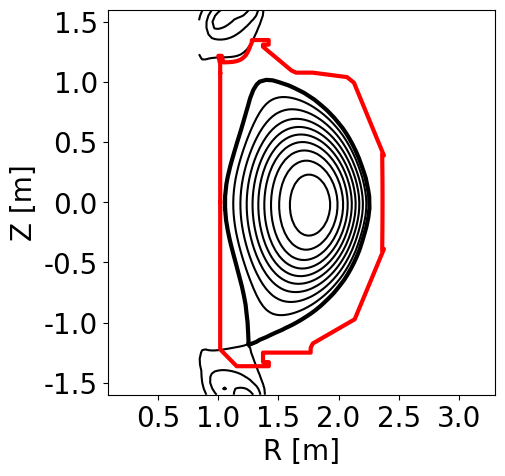

t_bounce 3.630359923550518e-05 [s]


In [3]:
print('Rmin: ', np.min(mcgo_pp.eqdsk['rlim']))
print('Rmax: ', np.max(mcgo_pp.eqdsk['rlim']))
mcgo_pp.plot_equilibrium(figsize=(5,5), levels=[.1,.2,.3,.4,.5,.6, .7,.8,.9,1])

R0 = 1
q = 2
mpart = 3.343e-27
Epart = 5 * 1000 * 1.6022e-19
t_bounce = 4*np.pi*R0*q/np.sqrt(2*Epart/mpart)
print(f't_bounce {t_bounce} [s]')

/home/jacobvandelindt/aorsa_cql_mcgo_toolkit/aorsa_env/lib/python3.8/site-packages/f90nml/parser.py:826: UserWarning: f90nml: warning: Value 0.0 is not assigned to any variable and has been removed.
  warnings.warn(
/home/jacobvandelindt/aorsa_cql_mcgo_toolkit/aorsa_env/lib/python3.8/site-packages/f90nml/parser.py:826: UserWarning: f90nml: warning: Value 5e+18 is not assigned to any variable and has been removed.
  warnings.warn(
/home/jacobvandelindt/aorsa_cql_mcgo_toolkit/aorsa_env/lib/python3.8/site-packages/f90nml/parser.py:826: UserWarning: f90nml: warning: Value 1e+16 is not assigned to any variable and has been removed.
  warnings.warn(
/home/jacobvandelindt/aorsa_cql_mcgo_toolkit/aorsa_env/lib/python3.8/site-packages/f90nml/parser.py:826: UserWarning: f90nml: warning: Value 7e+18 is not assigned to any variable and has been removed.
  warnings.warn(
/home/jacobvandelindt/aorsa_cql_mcgo_toolkit/aorsa_env/lib/python3.8/site-packages/f90nml/parser.py:826: UserWarning: f90nml: warn

Text(0.5, 1.0, 'Genray Shot Profiles')

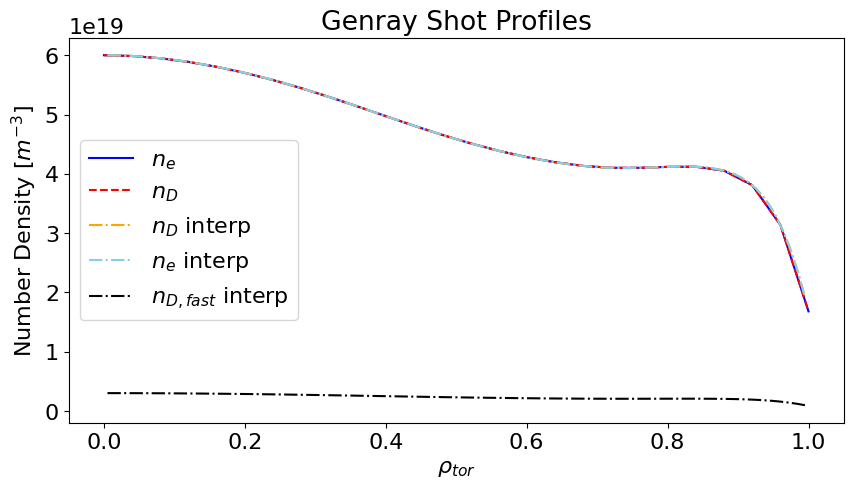

In [4]:
# set up ion and electron temp and density profiles 
rgrid_mcgo = np.linspace(5.0000e-03, 0.995, 100)

# read in genray profiles 
gnr_input_path = '/home/jacobvandelindt/aorsa_cql_mcgo_toolkit/shots/147634/genray.in'
gnr_nml = f90.read(gnr_input_path)
plt.rcParams.update({'font.size': 16})
dentab = gnr_nml['dentab']['prof']
den = np.array(dentab).reshape(26,3)
den_scale = gnr_nml['plasma']['den_scale']
ndens = gnr_nml['plasma']['ndens']
rgrid = np.linspace(0, 1, ndens)

# make ion and electron density interpolator 
fast_density_factor = 0.05 # TODO this is random
ne = den[:,0]*den_scale[0]
nD = den[:,1]*den_scale[1]
#nDfast = den[:,2]*den_scale[2]
fne = interp1d(rgrid, ne, kind='cubic')
fni = interp1d(rgrid, nD, kind='cubic')
fni_fast = interp1d(rgrid, nD*fast_density_factor, kind='cubic')

plt.figure(figsize=(10,5))
plt.plot(rgrid, ne, label=r'$n_e$', color='blue')
plt.plot(rgrid, nD, label=r'$n_D$', color='red', linestyle='dashed')
plt.plot(rgrid_mcgo, fni(rgrid_mcgo), label=r'$n_D$ interp', color='orange', linestyle='-.')
plt.plot(rgrid_mcgo, fne(rgrid_mcgo), label=r'$n_e$ interp', color='skyblue', linestyle='-.')
plt.plot(rgrid_mcgo, fni_fast(rgrid_mcgo), label=r'$n_{D,fast}$ interp', color='black', linestyle='-.')
#plt.plot(rgrid, nDfast, label=r'$n_{D, fast}$', color='orange')
plt.legend()
plt.xlabel(r'$\rho_{tor}$')
plt.ylabel(r'Number Density [$m^{-3}$]')
plt.title('Genray Shot Profiles')

Text(0.5, 1.0, 'Genray Shot Profiles')

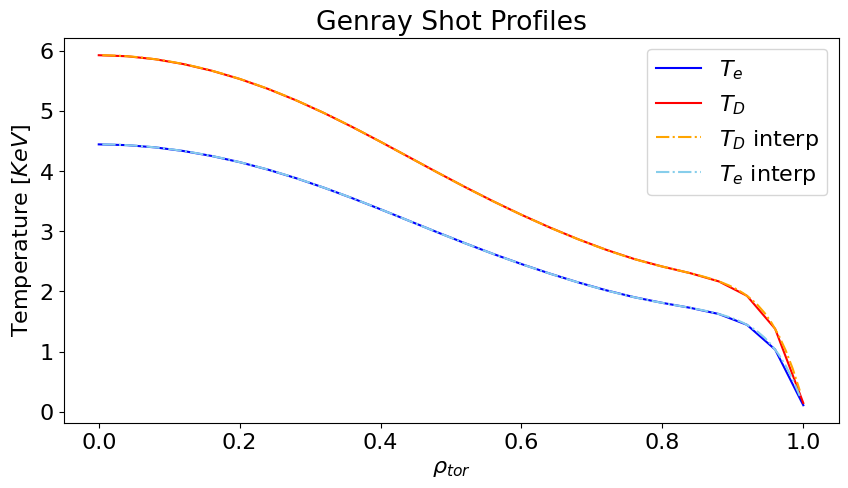

In [5]:
temtab = gnr_nml['temtab']['prof']
tem = np.array(temtab).reshape(26,3)
tem_scale = gnr_nml['plasma']['temp_scale']
ndens = gnr_nml['plasma']['ndens']
rgrid = np.linspace(0, 1, ndens)
Te = tem[:,0]*tem_scale[0]
TD = tem[:,1]*tem_scale[1]
TDfast = tem[:,2]*tem_scale[2]
fTe = interp1d(rgrid, Te, kind='cubic')
fTi = interp1d(rgrid, TD, kind='cubic')

plt.figure(figsize=(10,5))
plt.plot(rgrid, Te, label=r'$T_e$', color='blue')
plt.plot(rgrid, TD, label=r'$T_D$', color='red')
plt.plot(rgrid_mcgo, fTi(rgrid_mcgo), label=r'$T_D$ interp', color='orange', linestyle='-.')
plt.plot(rgrid_mcgo, fTe(rgrid_mcgo), label=r'$T_e$ interp', color='skyblue', linestyle='-.')
#plt.plot(rgrid, TDfast, label=r'$T_{D, fast}$', color='orange')
plt.legend()
plt.xlabel(r'$\rho_{tor}$')
plt.ylabel(r'Temperature [$KeV$]')
plt.title('Genray Shot Profiles')

In [6]:
# load up these profiles into the mcgo input file. 

# update densities and temperatures. 
infile = '/home/jacobvandelindt/aorsa_cql_mcgo_toolkit/shots/147634/mcgoinput_2speci'
outfile = '/home/jacobvandelindt/aorsa_cql_mcgo_toolkit/shots/147634/mcgoinput_2speci_out'

updates = {'rte': rgrid_mcgo.tolist(),
           'te': fTe(rgrid_mcgo).tolist(),
           'rti': rgrid_mcgo.tolist(),
           'ti': fTi(rgrid_mcgo).tolist(),
           'rni(1,1)': rgrid_mcgo.tolist(),
           'eni(1,1)': (fni_fast(rgrid_mcgo)/1e6).tolist(),
           'rni(1,2)': rgrid_mcgo.tolist(),
           'eni(1,2)': (fni(rgrid_mcgo)/1e6).tolist()} 

mcgo_pp.update_fortran_input_deck(input_file=infile, updates=updates, out_file=outfile)


In [7]:
# Section 2: Post Processing
mcgo_nc_file = '/home/jacobvandelindt/aorsa_cql_mcgo_toolkit/shots/147634/mcgo.nc'
mcgo_pp.read_mcgo_nc(mcgo_nc_file=mcgo_nc_file)

In [8]:

print(mcgo_pp.rho_grid)
print(mcgo_pp.mcgo_nc.variables['radbnd'][:])
print(mcgo_pp.eqdsk['zmaxis'])
print(mcgo_pp.mcgo_nc.variables.keys())
print(mcgo_pp.mcgo_nc.variables['rend'].shape)

[0.9998444  0.9534384  0.8962468  0.82553977 0.7417026  0.64833724
 0.5519212  0.45801938 0.36548197 0.26943955 0.1652045  0.05028231
 0.07443299 0.20528738 0.3387718  0.47443417 0.61385936 0.7518
 0.87936    0.999867  ]
[1.0556788 1.118934  1.1821891 1.2454443 1.3086994 1.3719546 1.4352098
 1.4984648 1.56172   1.6249751 1.6882303 1.7514855 1.8147405 1.8779957
 1.9412508 2.0045059 2.0677612 2.1310163 2.1942713 2.2575266]
-0.0231968987
dict_keys(['version', 'mnemonic', 'eqdskin', 'raxis', 'zaxis', 'xlimiter', 'ylimiter', 'rcontr', 'zcontr', 'nparts_tot', 'mf', 'rhobincent', 'rps_bincent', 'npol_start', 'irbnd', 'ivbnd', 'iptchbnd', 'ptchbnd', 'vbnd', 'radbnd', 'psibin', 'rho_sqpolflx', 'vdstb', 'rst', 'zst', 'rend', 'zend', 'vparend', 'vperend', 'ivparini'])
(763095,)


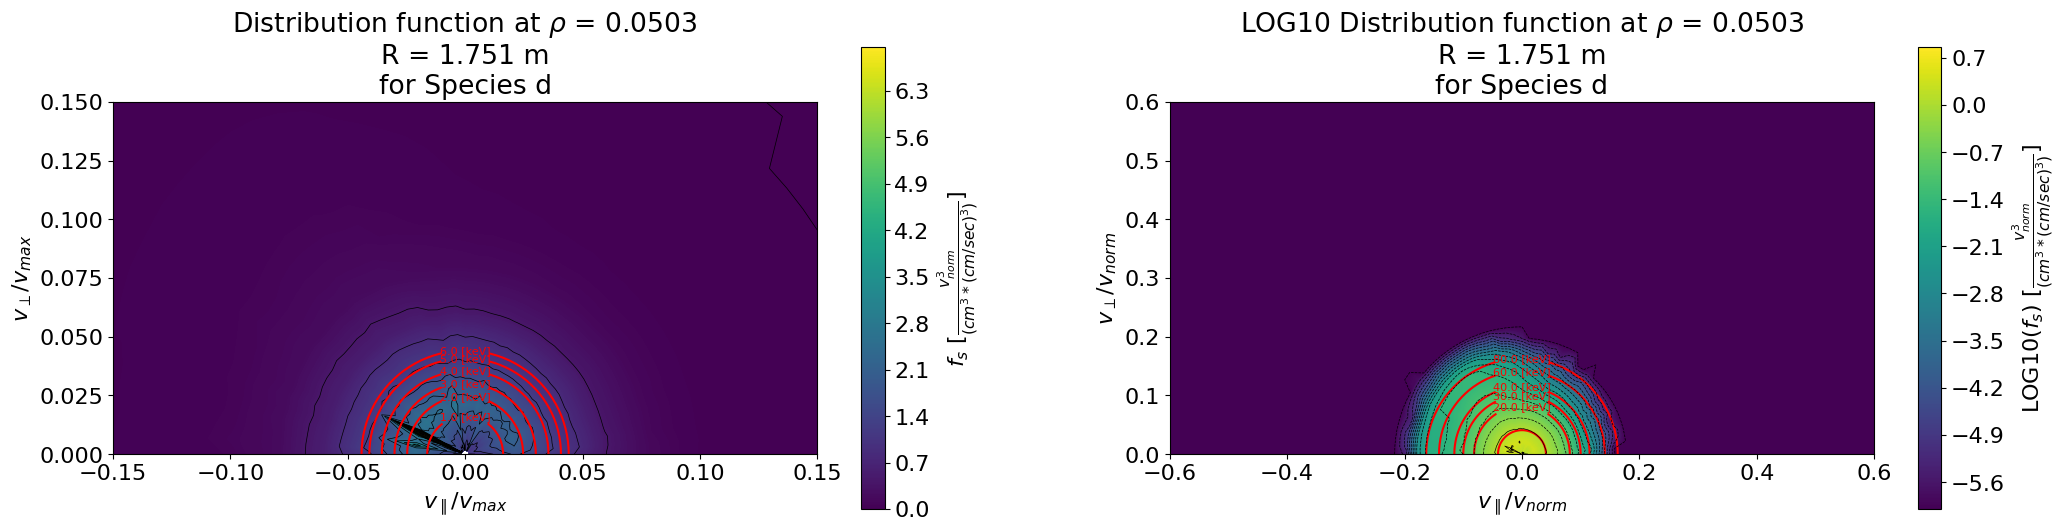

In [9]:
# try out plotting
rho_idx = 11
mcgo_pp.plot_distribution_function_at_rho(
        rho_index=rho_idx,
        v_norm_over_v_max=0.15,
        log_scale_axis_multiple=4,
        log_clip_level=1e-6,
        figsize=(25, 6),
        cmap="viridis",
        num_energy_levels=6,
        energy_levels_linear=[1,2,3,4,5,6],
        energy_levels_log=[5, 20, 30, 40, 60, 80],
        energy_color="red",
        return_plot=False,
        use_interpolated_rho=False,
        rho_to_interpolate_to=None,
        plot_trapped_passing=False)

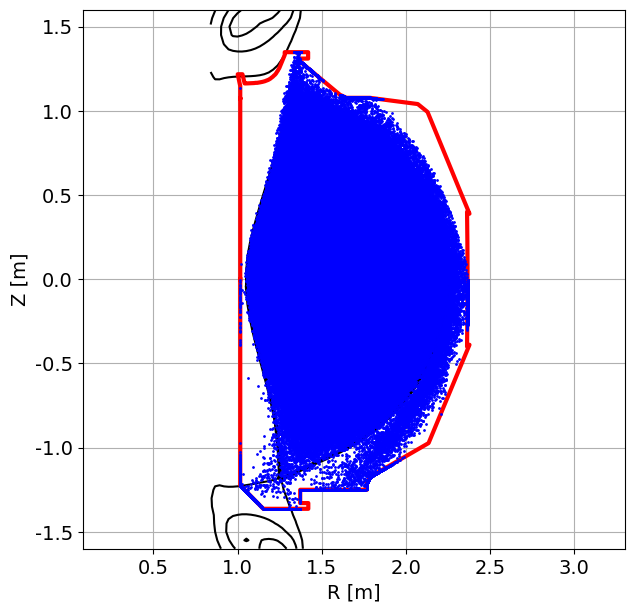

In [10]:
mcgo_pp.plot_particle_end_RZ(figsize=(7,7), levels=[.1,.2,.3,.4,.5,.6, .7,.8,.9,1], fontsize=14, dotsize=2, return_plot=False)

In [11]:
# now, lets try and generate the p2f particle list, run p2f, and then plot the results here! 
filename='/home/jacobvandelindt/aorsa_cql_mcgo_toolkit/shots/147634/mcgo_p2f_plist.nc'
weight = 1e13
mcgo_pp.p2f_convert_mcgo_particle_list_to_p2f_particle_list(filename, weight=weight)

File saved to /home/jacobvandelindt/aorsa_cql_mcgo_toolkit/shots/147634/mcgo_p2f_plist.nc
Number of particles: 763095


In [12]:
# load p2f results 
p2f_out_file = '/home/jacobvandelindt/aorsa_cql_mcgo_toolkit/shots/147634/p2f.nc'

mcgo_pp.load_p2f_output(p2f_out_file=p2f_out_file)
print(mcgo_pp.p2f_out.variables.keys())
print(mcgo_pp.p2f_out.variables['vPar_binCenters'][:].shape)
print(mcgo_pp.p2f_out.variables['vPer_binCenters'][:].shape)
print(mcgo_pp.p2f_out.variables['R_binCenters'][:].shape)
print(mcgo_pp.p2f_out.variables['z_binCenters'][:].shape)
print(mcgo_pp.p2f_out.variables['f_rzvv'][:].shape)
print(mcgo_pp.p2f_out.variables['f_rzvv'].dimensions)
np.isnan(mcgo_pp.p2f_out.variables['f_rzvv'][:]).any()

dict_keys(['f_rzvv', 'R_binCenters', 'z_binCenters', 'vPer_binCenters', 'vPar_binCenters', 'R_binEdges', 'z_binEdges', 'vPer_binEdges', 'vPar_binEdges', 'nP', 'R_binSize', 'z_binSize', 'vPer_binSize', 'vPar_binSize', 'vPar_range', 'vPer_range', 'density'])
(129,)
(65,)
(128,)
(128,)
(129, 65, 128, 128)
('vPar_nBins', 'vPer_nBins', 'z_nBins', 'R_nBins')


False

In [19]:
# save working section to entire array 
f_python = np.transpose(mcgo_pp.p2f_out.variables['f_rzvv'][:], (3, 2, 1, 0))
Rarray = mcgo_pp.p2f_out.variables['R_binCenters'][:]
Zarray = mcgo_pp.p2f_out.variables['z_binCenters'][:]
vpar_array = mcgo_pp.p2f_out.variables['vPar_binCenters'][:]
vper_array = mcgo_pp.p2f_out.variables['vPer_binCenters'][:]

In [21]:
# refill with working slice 
f_save = np.zeros_like(f_python)
iR = 64
iZ = 64
for iiR in range(Rarray.shape[0]):
    for iiZ in range(Zarray.shape[0]):
        f_save[iiR,iiZ, :, :] = f_python[iR,iZ,:,:]

In [23]:
def write_f_rzvv_nc(filename, R_centers, Z_centers, vPer_centers, vPar_centers, f_rzvv):
    """
    Write f_rzvv to NetCDF in the same convention as p2f.

    Parameters
    ----------
    filename : str
        Output .nc filename
    R_centers, Z_centers, vPer_centers, vPar_centers : 1D arrays
        Bin centers
    f_rzvv : ndarray, shape (nR, nZ, nVper, nVpar)
        Distribution function in Python order [R, Z, vPer, vPar]
    """

    # Sanity checks
    nR, nZ, nVper, nVpar = f_rzvv.shape
    assert len(R_centers) == nR
    assert len(Z_centers) == nZ
    assert len(vPer_centers) == nVper
    assert len(vPar_centers) == nVpar

    # Convert to Fortran order for NetCDF
    # Python (R,Z,vPer,vPar) -> NetCDF (vPar,vPer,Z,R)
    f_to_save = np.transpose(f_rzvv, (3, 2, 1, 0))

    with Dataset(filename, "w", format="NETCDF4") as nc:
        # Dimensions
        nc.createDimension("R_nBins", nR)
        nc.createDimension("z_nBins", nZ)
        nc.createDimension("vPer_nBins", nVper)
        nc.createDimension("vPar_nBins", nVpar)

        nc.createDimension("R_nBins_p1", nR+1)
        nc.createDimension("z_nBins_p1", nZ+1)
        nc.createDimension("vPer_nBins_p1", nVper+1)
        nc.createDimension("vPar_nBins_p1", nVpar+1)

        nc.createDimension("scalar", 1)

        # Variables
        fvar = nc.createVariable("f_rzvv", "f4",
                                 ("vPar_nBins", "vPer_nBins", "z_nBins", "R_nBins"))
        Rvar = nc.createVariable("R_binCenters", "f4", ("R_nBins",))
        Zvar = nc.createVariable("z_binCenters", "f4", ("z_nBins",))
        vPervar = nc.createVariable("vPer_binCenters", "f4", ("vPer_nBins",))
        vParvar = nc.createVariable("vPar_binCenters", "f4", ("vPar_nBins",))

        # Assign data
        fvar[:, :, :, :] = f_to_save
        Rvar[:] = R_centers
        Zvar[:] = Z_centers
        vPervar[:] = vPer_centers
        vParvar[:] = vPar_centers

        # Example scalar metadata
        nc.createVariable("nP", "i4", ("scalar",))[:] = [0]
        nc.createVariable("R_binSize", "f4", ("scalar",))[:] = [R_centers[1]-R_centers[0]]
        nc.createVariable("z_binSize", "f4", ("scalar",))[:] = [Z_centers[1]-Z_centers[0]]
        nc.createVariable("vPer_binSize", "f4", ("scalar",))[:] = [vPer_centers[1]-vPer_centers[0]]
        nc.createVariable("vPar_binSize", "f4", ("scalar",))[:] = [vPar_centers[1]-vPar_centers[0]]

        # Optional: edges
        nc.createVariable("R_binEdges", "f4", ("R_nBins_p1",))[:] = np.linspace(R_centers[0], R_centers[-1], nR+1)
        nc.createVariable("z_binEdges", "f4", ("z_nBins_p1",))[:] = np.linspace(Z_centers[0], Z_centers[-1], nZ+1)
        nc.createVariable("vPer_binEdges", "f4", ("vPer_nBins_p1",))[:] = np.linspace(vPer_centers[0], vPer_centers[-1], nVper+1)
        nc.createVariable("vPar_binEdges", "f4", ("vPar_nBins_p1",))[:] = np.linspace(vPar_centers[0], vPar_centers[-1], nVpar+1)

        # Metadata
        nc.title = "Python-generated test f_rzvv, stored in Fortran-compatible order"

    print(f"✅ Wrote {filename} with f_rzvv shape {f_rzvv.shape} (Python) → {f_to_save.shape} (NetCDF)")

In [24]:
write_f_rzvv_nc(filename='p2f_just_center.nc', 
                R_centers=Rarray, 
                Z_centers=Zarray, 
                vPer_centers=vper_array, 
                vPar_centers=vpar_array,
                f_rzvv=f_save)

✅ Wrote p2f_just_center.nc with f_rzvv shape (128, 128, 65, 129) (Python) → (129, 65, 128, 128) (NetCDF)


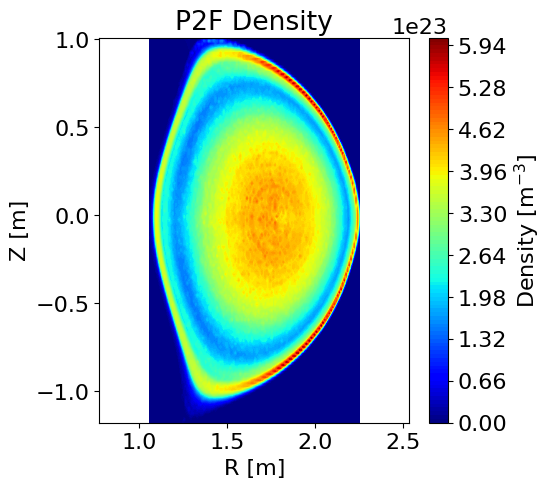

In [13]:
# plot the density
mcgo_pp.p2f_plot_density_RZ(figsize=(8,8))

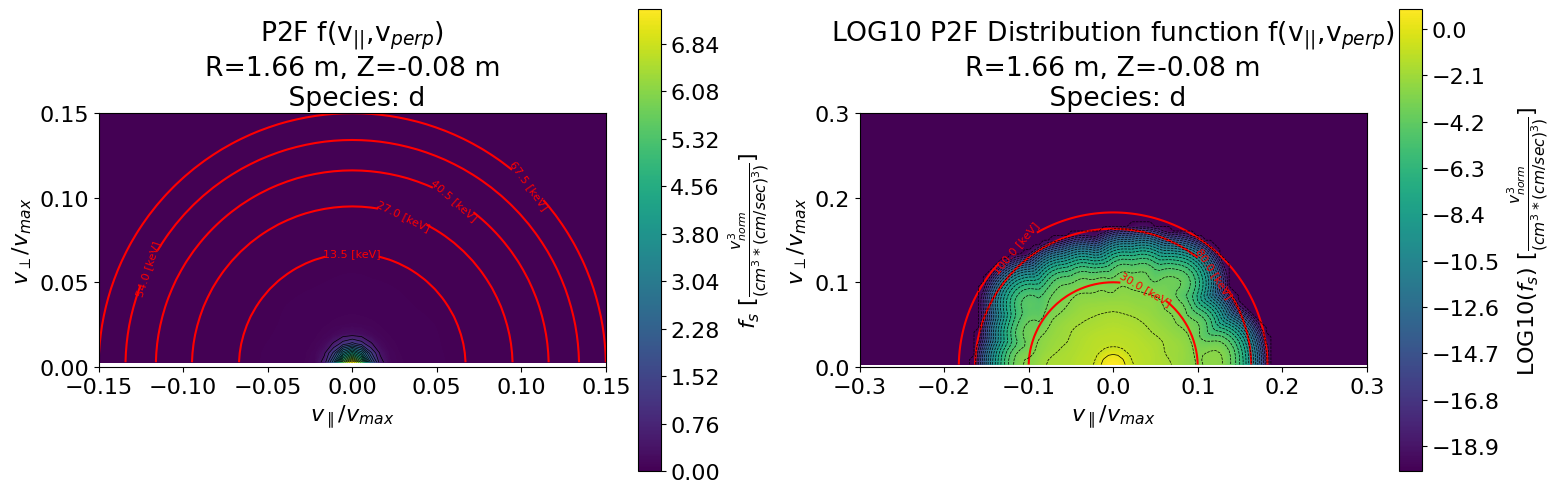

In [22]:
# plot the velocity distribution function 
iR = 64
iZ = 64
mcgo_pp.p2f_plot_distribution_function_at_RZ(
        R_index=iR,
        Z_index=iZ,
        v_norm_over_v_max=0.15,
        log_scale_axis_multiple=2,
        log_clip_level=1e-20,
        figsize=(18, 6),
        cmap="viridis",
        num_energy_levels=6,
        energy_levels_linear=None,
        energy_levels_log=[30, 80, 100],
        energy_color="red",
        return_plot=False,
        use_interpolated_rho=False,
        rho_to_interpolate_to=None,
        plot_trapped_passing=False)

['   90   86\n']


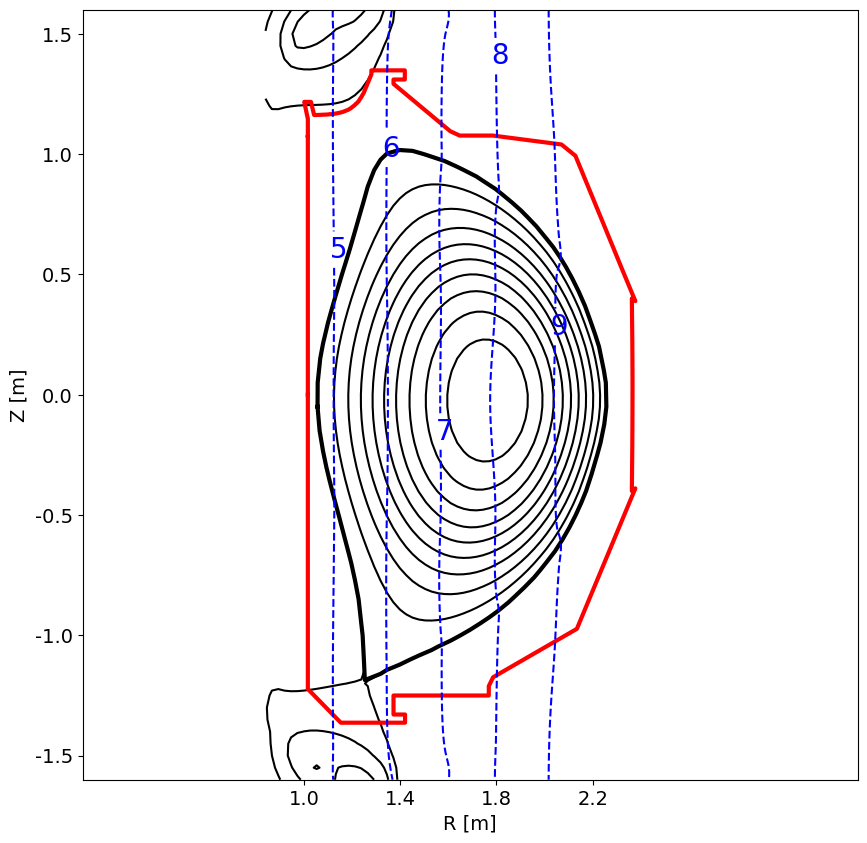

In [15]:
orbit_plot_obj = Orbit_Plotter(eqdsk_file=eqdsk_file, species='d')
orbit_plot_obj.plot_cyclotron_harmonics(
        frequency=96e6,
        harmonics=[5,6,7,8,9],
        species_mass=orbit_plot_obj.species_dict['d']['mass'],
        species_charge=orbit_plot_obj.species_dict['d']['charge'],
        r_resolution=200,
        z_resolution=200,
        levels=[.1,.2,.3,.4,.5,.6, .7,.8,.9,1],
        fontsize=14,
        figsize=(10, 10),
        harmonic_color="blue",
        return_plot=False,
        xticks=[1.0, 1.4, 1.8, 2.2],
    )

In [16]:
print(orbit_plot_obj.eqdsk_with_B_info["bzrz"].shape)
print(orbit_plot_obj.eqdsk_with_B_info["rgrid"].shape)
print(orbit_plot_obj.eqdsk_with_B_info["zgrid"].shape)

orbit_plot_obj.bz_interp((1.9,0))

(65, 65)
(65,)
(65,)


array(-0.11386442)

In [17]:
r0 = np.array([2.2, 0, 0])
# Ekev = 80
# vth = np.sqrt(Ekev * 1000 * 1.6022e-19 * 2 / (orbit_plot_obj.species_dict['d']['mass']))
# v0 = np.array([vth/np.sqrt(3), 1.0*vth/np.sqrt(3), vth/np.sqrt(3)])
Ekev = 80
vth = np.sqrt(Ekev * 1000 * 1.6022e-19 * 2 / (orbit_plot_obj.species_dict['d']['mass']))
v0 = np.array([vth/np.sqrt(3), 1.0*vth/np.sqrt(3), vth/np.sqrt(3)])
xarray, yarray, zarray = orbit_plot_obj.run_boris(r0=r0, v0=v0, nt=5000, dt=1e-8) # 5000 for case

In [18]:
r0 = np.array([2.2, 0, 0])
# Ekev = 80
# vth = np.sqrt(Ekev * 1000 * 1.6022e-19 * 2 / (orbit_plot_obj.species_dict['d']['mass']))
# v0 = np.array([vth/np.sqrt(3), 1.0*vth/np.sqrt(3), vth/np.sqrt(3)])
Ekev = .1
vth = np.sqrt(Ekev * 1000 * 1.6022e-19 * 2 / (orbit_plot_obj.species_dict['d']['mass']))
v0 = np.array([vth/np.sqrt(3), 1.0*vth/np.sqrt(3), vth/np.sqrt(3)])
xarray2, yarray2, zarray2 = orbit_plot_obj.run_boris(r0=r0, v0=v0, nt=5000, dt=5e-8) # 50000 for case

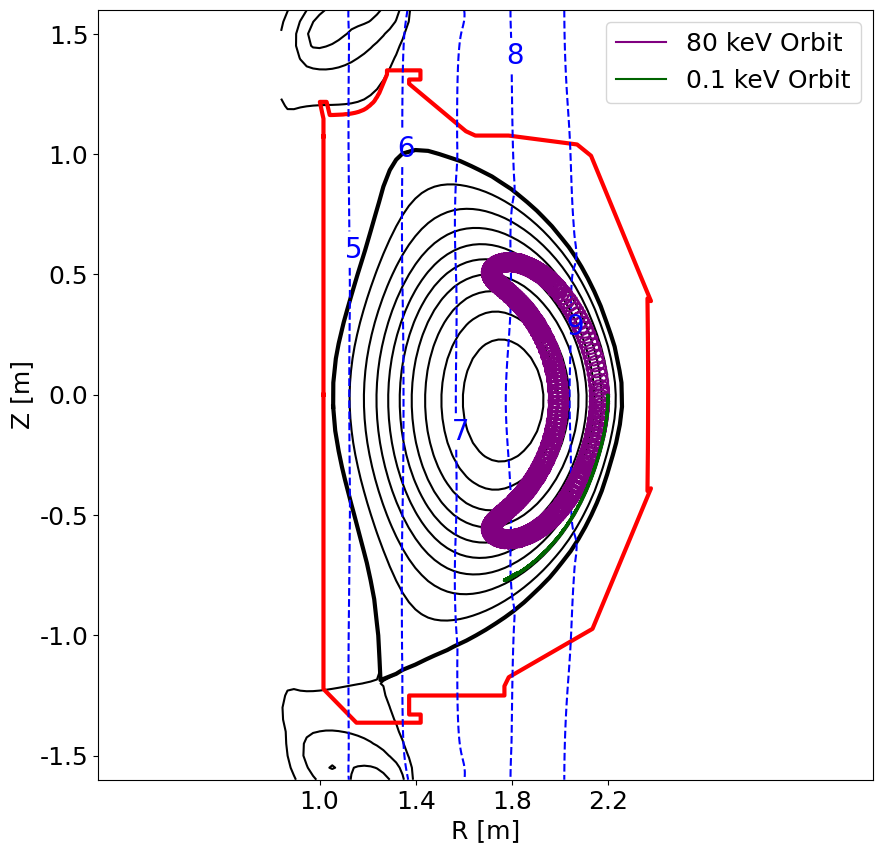

In [19]:

fig, ax = orbit_plot_obj.plot_cyclotron_harmonics(
        frequency=96e6,
        harmonics=[5,6,7,8,9],
        species_mass=orbit_plot_obj.species_dict['d']['mass'],
        species_charge=orbit_plot_obj.species_dict['d']['charge'],
        r_resolution=200,
        z_resolution=200,
        levels=[.1,.2,.3,.4,.5,.6, .7,.8,.9,1],
        fontsize=18,
        figsize=(10, 10),
        harmonic_color="blue",
        return_plot=True,
        xticks=[1.0, 1.4, 1.8, 2.2],
    )

ax.plot(np.sqrt(xarray**2 + yarray**2), zarray, color='purple', label='80 keV Orbit')
ax.plot(np.sqrt(xarray2**2 + yarray2**2), zarray2, color='darkgreen', label='0.1 keV Orbit')
ax.legend(fontsize=18)
# plt.plot(np.sqrt(xarray**2 + yarray**2),zarray)
# plt.axis('equal')

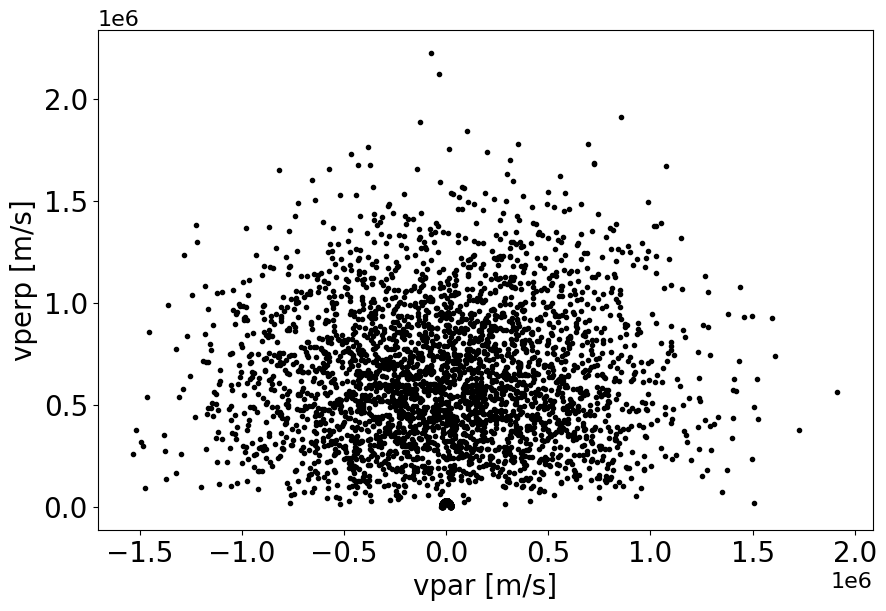

In [18]:
mcgo_pp.plot_bin_particles_RZ(NR=16, NZ=16, i=8, j=8, figsize=(10,10), fontsize=20)

In [14]:
# manually check derivatives of the p2f distribution of particles 

def read_f_rzvv_nc(filename):
    """
    Read f_rzvv from NetCDF (p2f convention) and return arrays in Python order:
        f_rzvv.shape = (nR, nZ, nVper, nVpar)

    Parameters
    ----------
    filename : str
        Path to .nc file

    Returns
    -------
    R_centers, Z_centers, vPer_centers, vPar_centers : 1D numpy arrays
    f_rzvv : 4D numpy array, shape (nR, nZ, nVper, nVpar)
    """
    with Dataset(filename, "r") as nc:
        R = nc.variables["R_binCenters"][:]
        Z = nc.variables["z_binCenters"][:]
        vPer = nc.variables["vPer_binCenters"][:]
        vPar = nc.variables["vPar_binCenters"][:]

        f_nc = nc.variables["f_rzvv"][:]  # stored as (vPar, vPer, Z, R)

    # Reorder to Python natural (R,Z,vPer,vPar)
    f_python = np.transpose(f_nc, (3, 2, 1, 0))

    return R, Z, vPer, vPar, f_python

# testing out my numerical derivatives 
def deriv_dfdvperp(f_rzvv, vPer, i_r, i_z):
    """
    df/dvper with f_rzvv shaped (n_vpar, n_vper, n_z, n_r).
    i_r, i_z are indices in R,Z (Python 0-based).
    Returns dfdvper slice of shape (n_vpar, n_vper).
    """
    n_r, n_z, n_vper, n_vpar = f_rzvv.shape
    dfdvper_slice = np.zeros((n_vper, n_vpar))

    for ivpar in range(n_vpar):
        for ivper in range(n_vper):
            if 0 < ivper < n_vper-1:
                dfdvper_slice[ivper, ivpar] = (
                    f_rzvv[i_r, i_z, ivper+1, ivpar] -
                    f_rzvv[i_r, i_z, ivper-1, ivpar]
                ) / (vPer[ivper+1] - vPer[ivper-1])

            elif ivper == 0 or ivper == n_vper-1:
                dfdvper_slice[ivper, ivpar] = 0.0

    return dfdvper_slice


def deriv_dfdvpar(f_rzvv, vPar, i_r, i_z):
    """
    df/dvpar with f_rzvv shaped (n_vpar, n_vper, n_z, n_r).
    i_r, i_z are indices in R,Z (Python 0-based).
    Returns dfdvpar slice of shape (n_vpar, n_vper).
    """
    n_r, n_z, n_vper, n_vpar = f_rzvv.shape
    dfdvpar_slice = np.zeros((n_vper, n_vpar))

    for ivper in range(n_vper):
        for ivpar in range(n_vpar):
            if 0 < ivpar < n_vpar-1:
                dfdvpar_slice[ivper, ivpar] = (
                    f_rzvv[i_r, i_z, ivper, ivpar+1] -
                    f_rzvv[i_r, i_z, ivper, ivpar-1]
                ) / (vPar[ivpar+1] - vPar[ivpar-1])

            elif ivpar == 0 or ivpar == n_vpar-1:
                dfdvpar_slice[ivper, ivpar] = 0.0

    return dfdvpar_slice

In [24]:
R, Z, vPer, vPar, f_saved = read_f_rzvv_nc(filename='/home/jacobvandelindt/aorsa_cql_mcgo_toolkit/shots/147634/p2f.nc')

print("Shapes:")
print("R:", R.shape)
print("Z:", Z.shape)
print("vPer:", vPer.shape)
print("vPar:", vPar.shape)
print("np.max(np.abs(vPar))",np.max(np.abs(vPar)))
print("f_saved:", f_saved.shape)  # should be (nR, nZ, nVper, nVpar)

print(np.isnan(f_saved.shape).any())

print('max f_rzvv:', np.max(f_saved))
print('min f_rzvv:', np.min(f_saved))

Shapes:
R: (128,)
Z: (128,)
vPer: (65,)
vPar: (129,)
np.max(np.abs(vPar)) 5953488.5
f_saved: (128, 128, 65, 129)
False
max f_rzvv: 3.2216763
min f_rzvv: 0.0


In [84]:
dfdvpar_all = np.zeros_like(f_saved)
dfdvper_all = np.zeros_like(f_saved)

for iR in range(f_saved.shape[0]):
    print(iR/R.shape[0], '% complete')
    for iZ in range(f_saved.shape[1]):
        dfdvpar_all[iR, iZ] = deriv_dfdvpar(f_saved, vPar, iR, iZ)
        dfdvper_all[iR, iZ] = deriv_dfdvperp(f_saved, vPer, iR, iZ)

0.0 % complete
0.0078125 % complete
0.015625 % complete
0.0234375 % complete


KeyboardInterrupt: 

In [83]:
# now, calculate the parallel derivative. R,Z doesnt matter

nan_found = False
for iR in range(R.shape[0]):
    for iZ in range(Z.shape[0]):
        dfdvpar = deriv_dfdvpar(f_rzvv=f_saved, vPar=vPar, i_r=iR, i_z=iZ)
        dfdvper = deriv_dfdvperp(f_rzvv=f_saved, vPer=vPer, i_r=iR, i_z=iZ)

        if np.isnan(dfdvper).any() or np.isnan(dfdvpar).any():
            print("NaN at iR:", iR, "iZ:", iZ)
            nan_found = True
            break

    if nan_found:
        break
        # print("Any NaNs in dfdvper?", np.isnan(dfdvper).any())
        # print("Any NaNs in dfdvpar?", np.isnan(dfdvpar).any())

KeyboardInterrupt: 

In [79]:
print(dfdvpar)
print("df/dvper slice:", dfdvper.shape)  # (n_vpar, n_vper)
print("df/dvpar slice:", dfdvpar.shape)  # (n_vpar, n_vper)

print("Any NaNs in dfdvper?", np.isnan(dfdvper).any())
print("Any NaNs in dfdvpar?", np.isnan(dfdvpar).any())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
df/dvper slice: (65, 129)
df/dvpar slice: (65, 129)
Any NaNs in dfdvper? False
Any NaNs in dfdvpar? False


In [33]:
dfdvpar =  deriv_dfdvpar(f_rzvv=f_saved, vPar=vPar/np.max(vPar), i_r=60, i_z=10)
dfdvper =  deriv_dfdvperp(f_rzvv=f_saved, vPer=vPer/np.max(vPar), i_r=60, i_z=10)

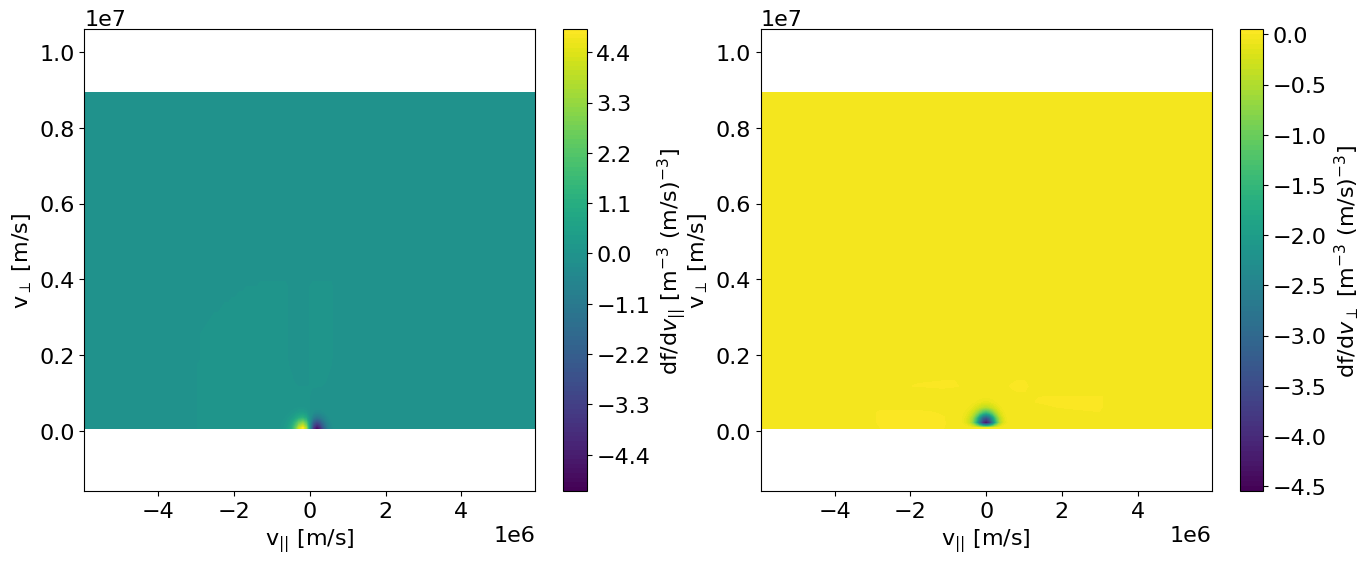

In [34]:
VPAR, VPER = np.meshgrid(vPar, vPer)
fig, ax = plt.subplots(1,2, figsize=(16,6))
cont = ax[0].contourf(VPAR, VPER, dfdvpar, levels=100, cmap="viridis")
ax[0].axis('equal')
# Add colorbar
cbar = fig.colorbar(cont, ax=ax[0])
cbar.set_label(r"df/d$v_{||}$ [m$^{-3}$ (m/s)$^{-3}$]")   # optional label
ax[0].set_xlabel(r'v$_{||}$ [m/s]')
ax[0].set_ylabel(r'v$_{\perp}$ [m/s]')

cont = ax[1].contourf(VPAR, VPER, dfdvper, levels=100, cmap="viridis")
ax[1].axis('equal')
# Add colorbar
cbar = fig.colorbar(cont, ax=ax[1])
cbar.set_label(r"df/d$v_{\perp}$ [m$^{-3}$ (m/s)$^{-3}$]")  # optional label
ax[1].set_xlabel(r'v$_{||}$ [m/s]')
ax[1].set_ylabel(r'v$_{\perp}$ [m/s]')

fac = 10